In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import os
import numpy as np
import cv2
import csv
from glob import glob
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from tqdm import tqdm
import random

In [7]:
# Some useful functions and definitions. You can skip this for now.

# A named tuple containing the intrinsics (calibration matrix K) and extrinsics (rotation matrix R, translation vector T) for a given camera.
Gt = namedtuple('Gt', ['K', 'R', 'T'])

# A small epsilon.
eps = 1e-15


def ReadCovisibilityData(filename):
    covisibility_dict = {}
    with open(filename) as f:
        reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(reader):
            # Skip header.
            if i == 0:
                continue
            covisibility_dict[row[1]] = float(row[2]) # the 1st column is the df index

    return covisibility_dict


def NormalizeKeypoints(keypoints, K):
    C_x = K[0, 2]
    C_y = K[1, 2]
    f_x = K[0, 0]
    f_y = K[1, 1]
    keypoints = (keypoints - np.array([[C_x, C_y]])) / np.array([[f_x, f_y]])
    return keypoints


def ComputeEssentialMatrix(F, K1, K2, kp1, kp2):
    '''Compute the Essential matrix from the Fundamental matrix, given the calibration matrices. Note that we ask participants to estimate F, i.e., without relying on known intrinsics.'''
    
    # Warning! Old versions of OpenCV's RANSAC could return multiple F matrices, encoded as a single matrix size 6x3 or 9x3, rather than 3x3.
    # We do not account for this here, as the modern RANSACs do not do this:
    # https://opencv.org/evaluating-opencvs-new-ransacs
    assert F.shape[0] == 3, 'Malformed F?'

    # Use OpenCV's recoverPose to solve the cheirality check:
    # https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0
    E = np.matmul(np.matmul(K2.T, F), K1).astype(np.float64)
    
    kp1n = NormalizeKeypoints(kp1, K1)
    kp2n = NormalizeKeypoints(kp2, K2)
    num_inliers, R, T, mask = cv2.recoverPose(E, kp1n, kp2n)

    return E, R, T


def ArrayFromCvKps(kps):
    '''Convenience function to convert OpenCV keypoints into a simple numpy array.'''
    
    return np.array([kp.pt for kp in kps])


def QuaternionFromMatrix(matrix):
    '''Transform a rotation matrix into a quaternion.'''

    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    m00 = M[0, 0]
    m01 = M[0, 1]
    m02 = M[0, 2]
    m10 = M[1, 0]
    m11 = M[1, 1]
    m12 = M[1, 2]
    m20 = M[2, 0]
    m21 = M[2, 1]
    m22 = M[2, 2]

    K = np.array([[m00 - m11 - m22, 0.0, 0.0, 0.0],
              [m01 + m10, m11 - m00 - m22, 0.0, 0.0],
              [m02 + m20, m12 + m21, m22 - m00 - m11, 0.0],
              [m21 - m12, m02 - m20, m10 - m01, m00 + m11 + m22]])
    K /= 3.0

    # The quaternion is the eigenvector of K that corresponds to the largest eigenvalue.
    w, V = np.linalg.eigh(K)
    q = V[[3, 0, 1, 2], np.argmax(w)]

    if q[0] < 0:
        np.negative(q, q)

    return q


def ExtractSiftFeatures(image, detector, num_features):
    '''Compute SIFT features for a given image.'''
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kp, desc = detector.detectAndCompute(gray, None)
    return kp[:num_features], desc[:num_features]


def ComputeErrorForOneExample(q_gt, T_gt, q, T, scale):
    '''Compute the error metric for a single example.
    
    The function returns two errors, over rotation and translation. These are combined at different thresholds by ComputeMaa in order to compute the mean Average Accuracy.'''
    
    q_gt_norm = q_gt / (np.linalg.norm(q_gt) + eps)
    q_norm = q / (np.linalg.norm(q) + eps)

    loss_q = np.maximum(eps, (1.0 - np.sum(q_norm * q_gt_norm)**2))
    err_q = np.arccos(1 - 2 * loss_q)

    # Apply the scaling factor for this scene.
    T_gt_scaled = T_gt * scale
    T_scaled = T * np.linalg.norm(T_gt) * scale / (np.linalg.norm(T) + eps)

    err_t = min(np.linalg.norm(T_gt_scaled - T_scaled), np.linalg.norm(T_gt_scaled + T_scaled))

    return err_q * 180 / np.pi, err_t


def ComputeMaa(err_q, err_t, thresholds_q, thresholds_t):
    '''Compute the mean Average Accuracy at different tresholds, for one scene.'''
    
    assert len(err_q) == len(err_t)
    
    acc, acc_q, acc_t = [], [], []
    for th_q, th_t in zip(thresholds_q, thresholds_t):
        acc += [(np.bitwise_and(np.array(err_q) < th_q, np.array(err_t) < th_t)).sum() / len(err_q)]
        acc_q += [(np.array(err_q) < th_q).sum() / len(err_q)]
        acc_t += [(np.array(err_t) < th_t).sum() / len(err_t)]
    return np.mean(acc), np.array(acc), np.array(acc_q), np.array(acc_t)


def BuildCompositeImage(im1, im2, axis=1, margin=0, background=1):
    '''Convenience function to stack two images with different sizes.'''
    
    if background != 0 and background != 1:
        background = 1
    if axis != 0 and axis != 1:
        raise RuntimeError('Axis must be 0 (vertical) or 1 (horizontal')

    h1, w1, _ = im1.shape
    h2, w2, _ = im2.shape

    if axis == 1:
        composite = np.zeros((max(h1, h2), w1 + w2 + margin, 3), dtype=np.uint8) + 255 * background
        if h1 > h2:
            voff1, voff2 = 0, (h1 - h2) // 2
        else:
            voff1, voff2 = (h2 - h1) // 2, 0
        hoff1, hoff2 = 0, w1 + margin
    else:
        composite = np.zeros((h1 + h2 + margin, max(w1, w2), 3), dtype=np.uint8) + 255 * background
        if w1 > w2:
            hoff1, hoff2 = 0, (w1 - w2) // 2
        else:
            hoff1, hoff2 = (w2 - w1) // 2, 0
        voff1, voff2 = 0, h1 + margin
    composite[voff1:voff1 + h1, hoff1:hoff1 + w1, :] = im1
    composite[voff2:voff2 + h2, hoff2:hoff2 + w2, :] = im2

    return (composite, (voff1, voff2), (hoff1, hoff2))


def DrawMatches(im1, im2, kp1, kp2, matches, axis=1, margin=0, background=0, linewidth=2):
    '''Draw keypoints and matches.'''
    
    composite, v_offset, h_offset = BuildCompositeImage(im1, im2, axis, margin, background)

    # Draw all keypoints.
    for coord_a, coord_b in zip(kp1, kp2):
        composite = cv2.drawMarker(composite, (int(coord_a[0] + h_offset[0]), int(coord_a[1] + v_offset[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1)
        composite = cv2.drawMarker(composite, (int(coord_b[0] + h_offset[1]), int(coord_b[1] + v_offset[1])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1)
    
    # Draw matches, and highlight keypoints used in matches.
    for idx_a, idx_b in matches:
        composite = cv2.drawMarker(composite, (int(kp1[idx_a, 0] + h_offset[0]), int(kp1[idx_a, 1] + v_offset[0])), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=12, thickness=1)
        composite = cv2.drawMarker(composite, (int(kp2[idx_b, 0] + h_offset[1]), int(kp2[idx_b, 1] + v_offset[1])), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=12, thickness=1)
        composite = cv2.line(composite,sr
                             tuple([int(kp1[idx_a][0] + h_offset[0]),
                                   int(kp1[idx_a][1] + v_offset[0])]),
                             tuple([int(kp2[idx_b][0] + h_offset[1]),
                                   int(kp2[idx_b][1] + v_offset[1])]), color=(0, 0, 255), thickness=1)
    return composite


def LoadCalibration(filename):
    '''Load calibration data (ground truth) from the csv file.'''
    
    calib_dict = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(reader):
            # Skip header.
            if i == 0:
                continue

            camera_id = row[1]
            K = np.array([float(v) for v in row[2].split(' ')]).reshape([3, 3])
            R = np.array([float(v) for v in row[3].split(' ')]).reshape([3, 3])
            T = np.array([float(v) for v in row[4].split(' ')])
            calib_dict[camera_id] = Gt(K=K, R=R, T=T)
    
    return calib_dict


In [9]:
# Input data files are available in the read-only "../input/" directory.

src = '/kaggle/input/cv-22928-2025-a-project/train'

val_scenes = []
for f in os.scandir(src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "test_images"" at /Users/yoav/Documents/Yoav/CS/22928 - Intro to CV/cv-final/data/external/test_images
Found scene "train"" at /Users/yoav/Documents/Yoav/CS/22928 - Intro to CV/cv-final/data/external/train


Loaded 0 images.


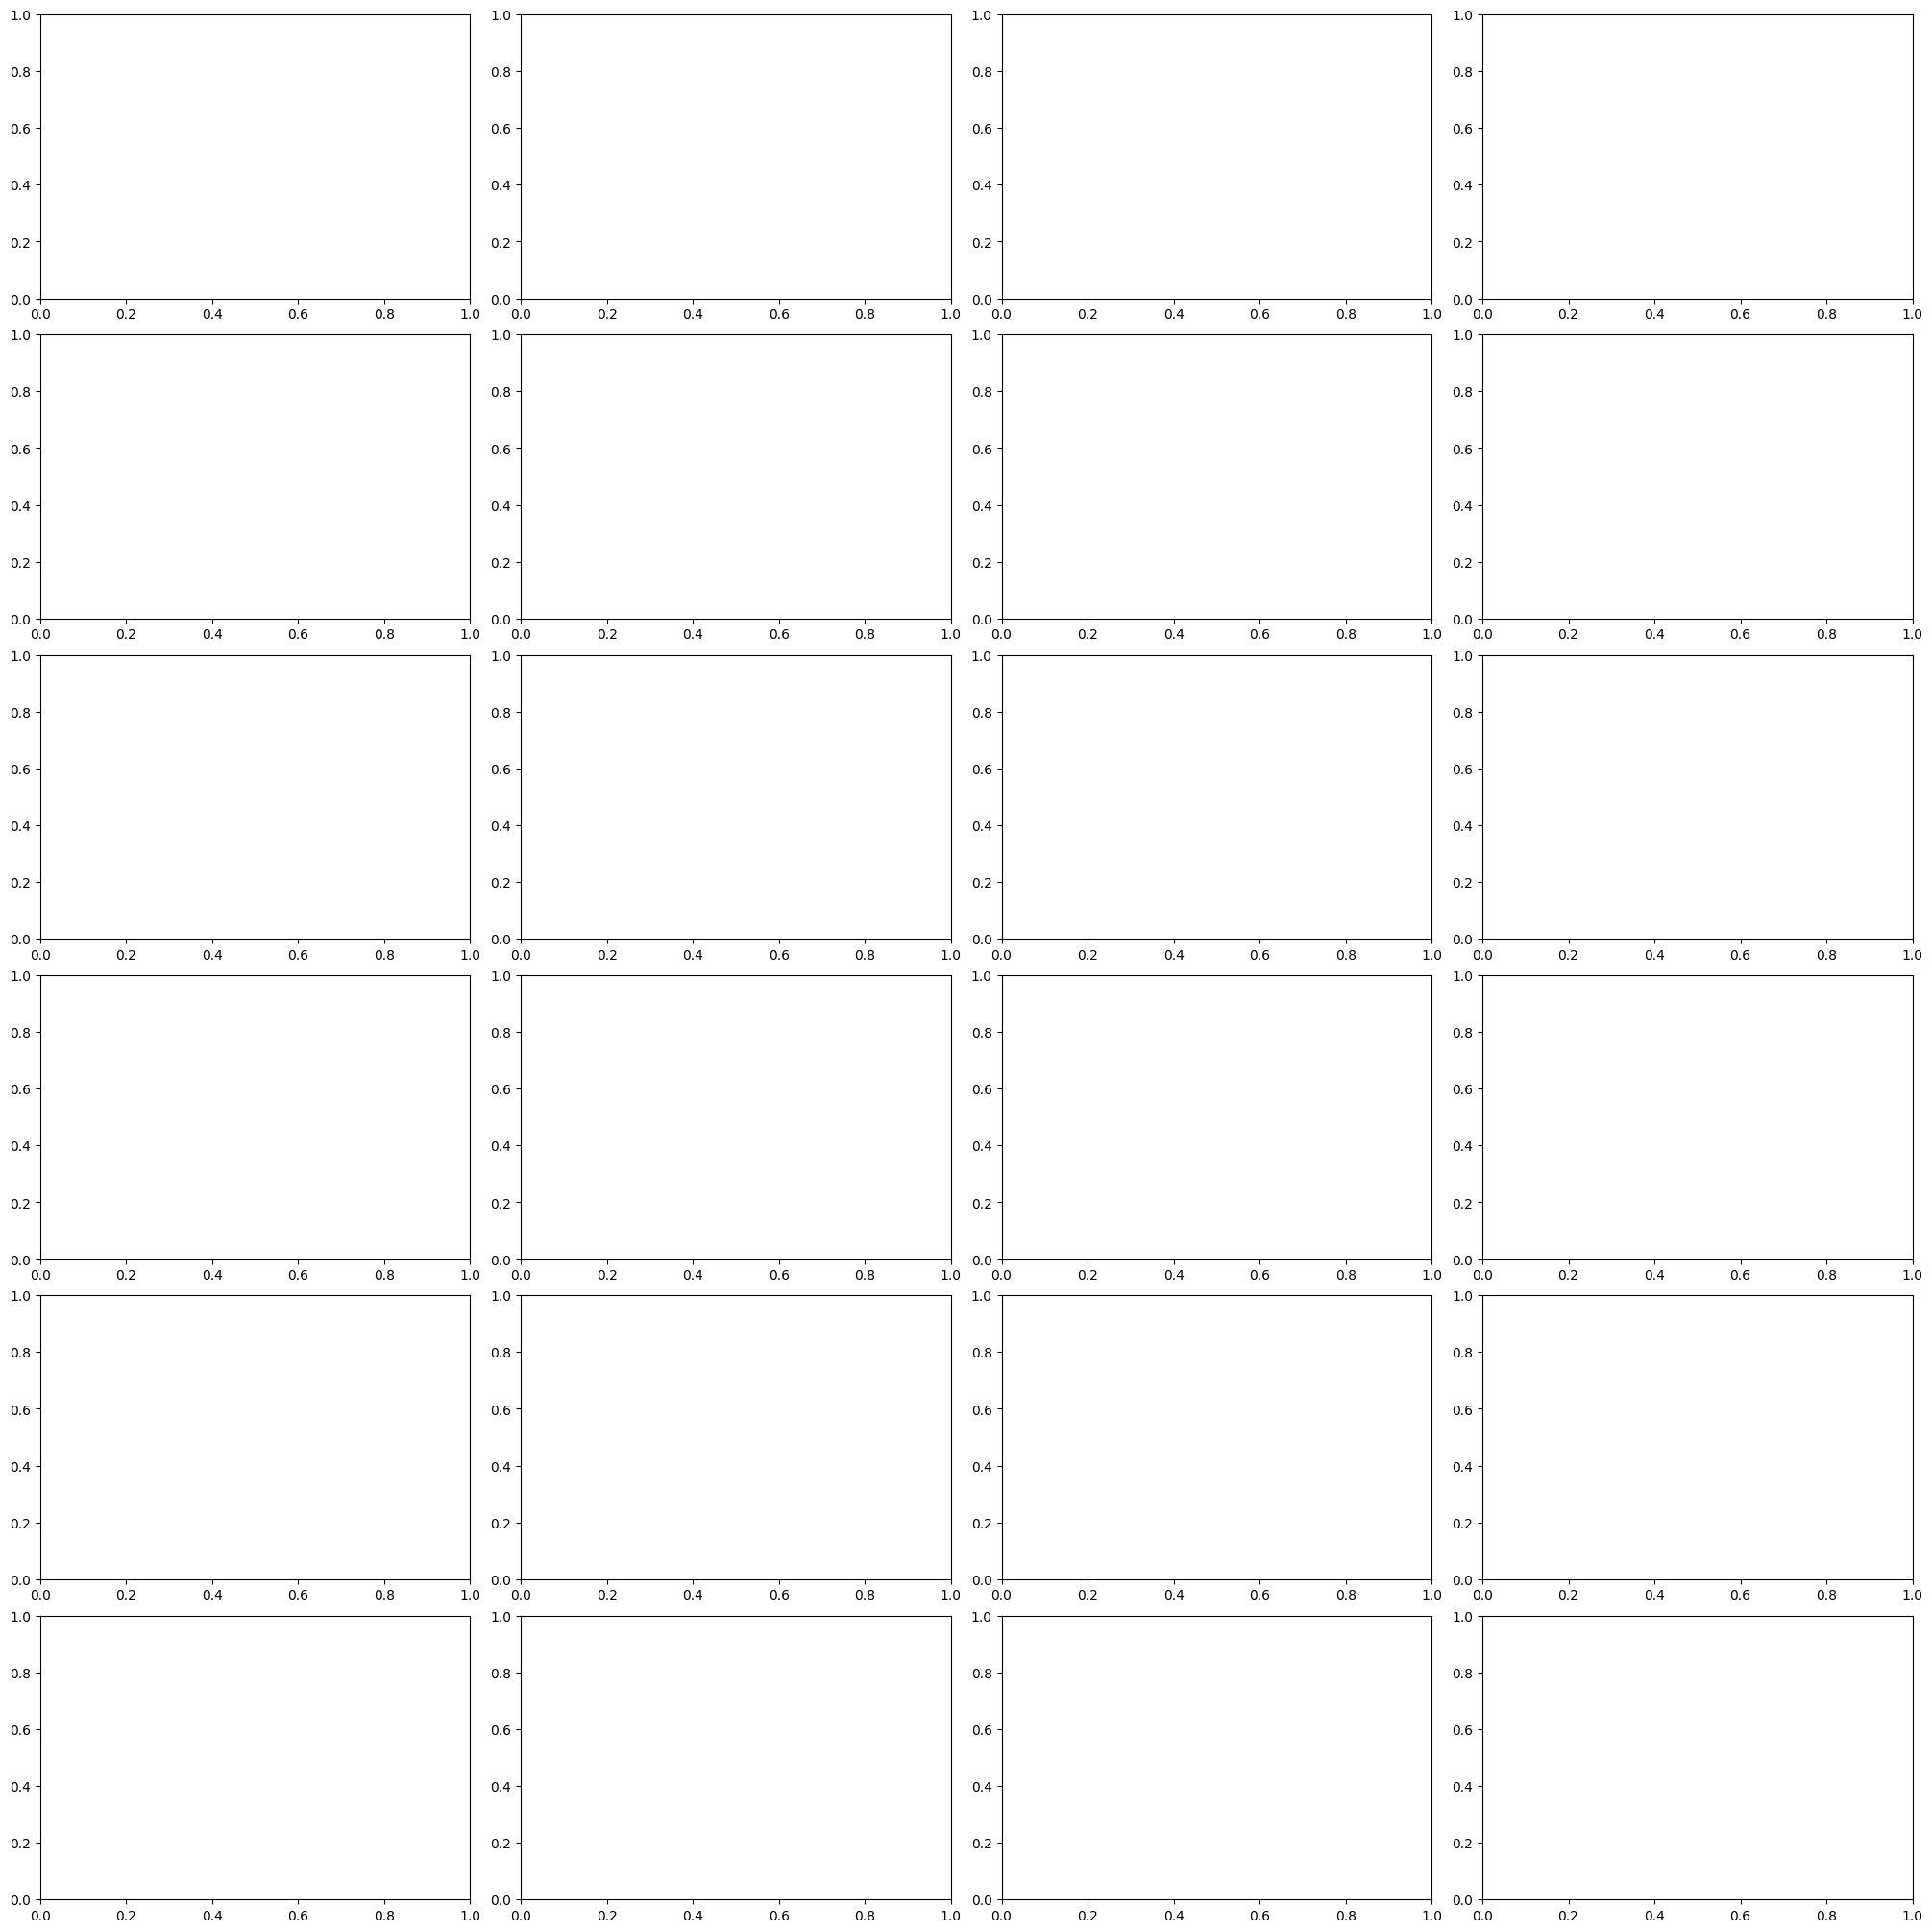

In [10]:
# Each scene in the validation set contains a list of images, poses, and pairs. Let's pick one and look at some images.

scene = 'british_museum'

images_dict = {}
for filename in glob(f'{src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])

    # OpenCV expects BGR, but the images are encoded in standard RGB, so you need to do color conversion if you use OpenCV for I/O.
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 6
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')

Pairs from an easy subset


KeyError: '93658023_4980549800'

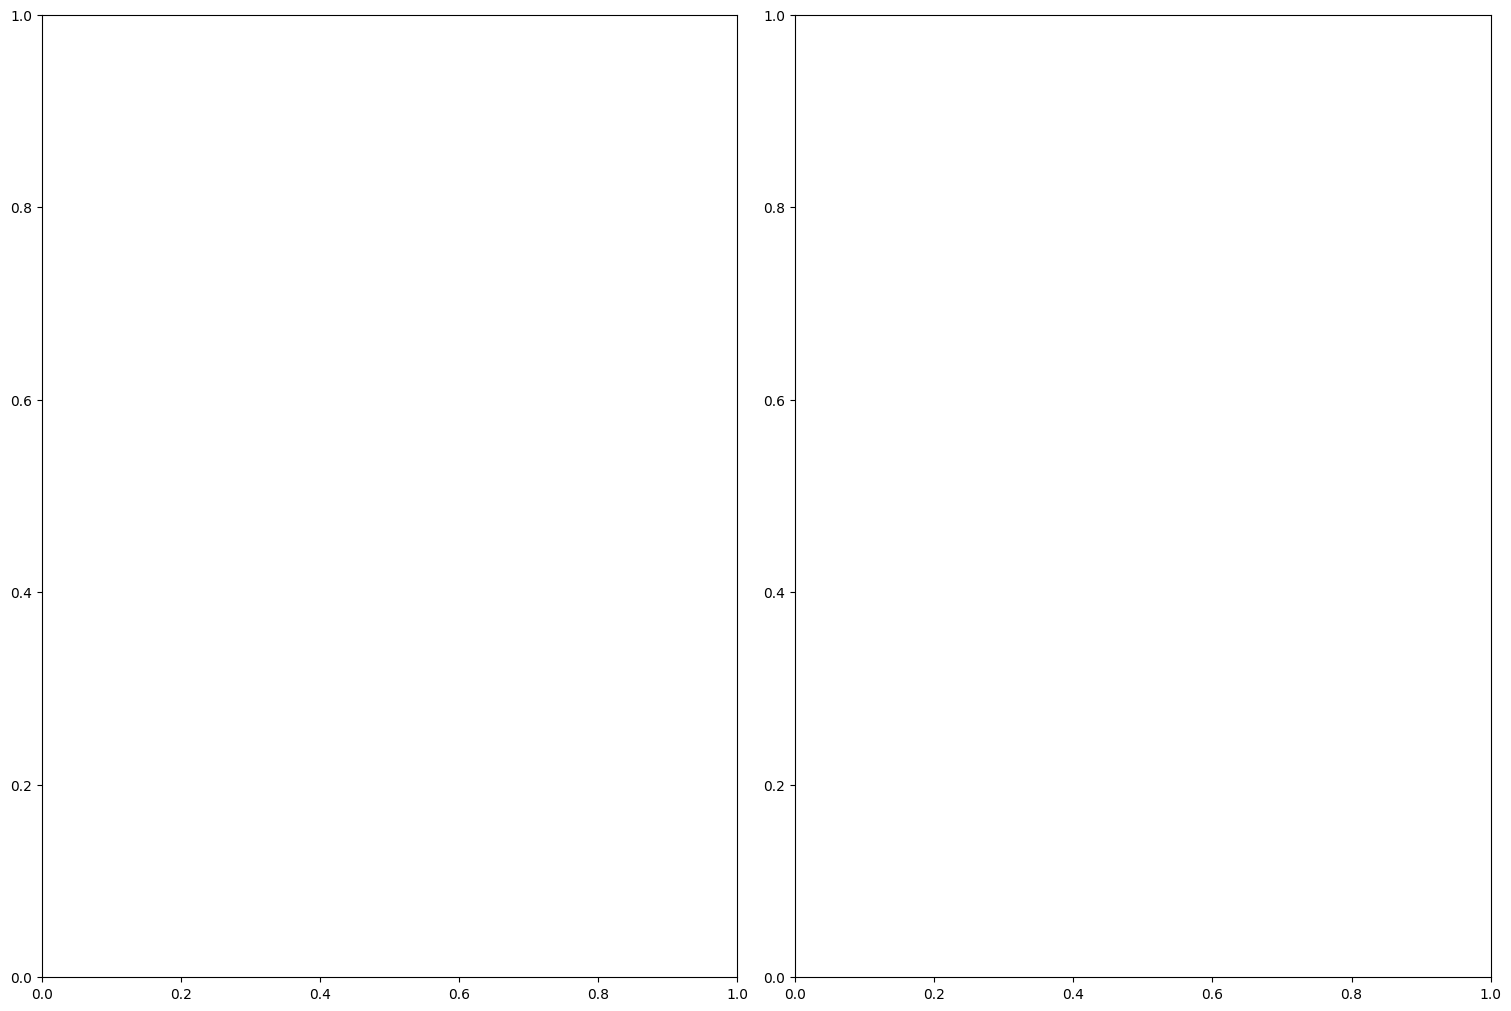

In [ ]:
# Two images from the same scene may not always overlap.
# The dataset contains co-visibility estimates that you can use to find pairs with more or less overlap.
# We recommend using all pairs with a co-visibility estimate of 0.1 or larger.
# For more details, please see Section 3.2 of the paper: https://arxiv.org/abs/2003.01587.

covisibility_dict = ReadCovisibilityData(f'{src}/{scene}/pair_covisibility.csv')

# Let's look at easy pairs first, and difficult pairs later.
easy_subset = [k for k, v in covisibility_dict.items() if v >= 0.7]
difficult_subset = [k for k, v in covisibility_dict.items() if v >= 0.1 and v < 0.2]

for i, subset in enumerate([easy_subset, difficult_subset]):
    print(f'Pairs from an {"easy" if i == 0 else "difficult"} subset')
    
    for pair in subset[:4]:
        # A pair string is simply two concatenated image IDs, separated with a hyphen.
        image_id_1, image_id_2 = pair.split('-')

        f, axes = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)
        axes[0].imshow(images_dict[image_id_1])
        axes[0].set_title(image_id_1)
        axes[1].imshow(images_dict[image_id_2])
        axes[1].set_title(image_id_2)
        for ax in axes:
            ax.axis('off')
        plt.show()

    print()
    print()

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
plt.title('Covisibility histogram')
plt.hist(list(covisibility_dict.values()), bins=10, range=[0, 1])
plt.show()

In [13]:
# The task is finding the relative geometry (rotation, translation) between the two cameras.
# You can read more about epipolar geometry here: https://en.wikipedia.org/wiki/Epipolar_geometry

# This problem is typically (but not always!) solved with sparse features.
# Let's try using SIFT, a seminal work in computer vision (https://en.wikipedia.org/wiki/Scale-invariant_feature_transform).
# No longer the state of the art, but still pretty solid!

num_features = 5000

# You may want to lower the detection threshold, as small images may not be able to reach the budget otherwise.
# Note that you may actually get more than num_features features, as a feature for one point can have multiple orientations (this is rare).
sift_detector = cv2.SIFT_create(num_features, contrastThreshold=-10000, edgeThreshold=-10000)

keys = list(images_dict.keys())
keypoints, descriptors = ExtractSiftFeatures(images_dict[keys[0]], sift_detector, num_features)
print(f'Computed {len(keypoints)} features.')

# Each local feature contains a keypoint (xy, possibly scale, possibly orientation) and a description vector (128-dimensional for SIFT).
image_with_keypoints = cv2.drawKeypoints(images_dict[keys[0]], keypoints, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig = plt.figure(figsize=(15, 15))
plt.imshow(image_with_keypoints)
plt.axis('off')
plt.show()

IndexError: list index out of range

In [ ]:
# We can find correspondences by brute-force-matching local features between two images. Let's do this for an easy pair.

pair = easy_subset[0]
image_id_1, image_id_2 = pair.split('-')
keypoints_1, descriptors_1 = ExtractSiftFeatures(images_dict[image_id_1], sift_detector, 2000)
keypoints_2, descriptors_2 = ExtractSiftFeatures(images_dict[image_id_2], sift_detector, 2000)

# For each descriptor on one image, find the closest descriptor on the other image.
# With crossCheck=True we keep only bidirectional matches (i.e., two features are nearest neighbours from A to B and also from B to A).
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Compute matches.
cv_matches = bf.match(descriptors_1, descriptors_2)

# Convert keypoints and matches to something more human-readable.
cur_kp_1 = ArrayFromCvKps(keypoints_1)
cur_kp_2 = ArrayFromCvKps(keypoints_2)
matches = np.array([[m.queryIdx, m.trainIdx] for m in cv_matches])

# Plot the brute-force matches.
im_matches = DrawMatches(images_dict[image_id_1], images_dict[image_id_2], cur_kp_1, cur_kp_2, matches)
fig = plt.figure(figsize=(25, 25))
plt.title('Matches before RANSAC')
plt.imshow(im_matches)
plt.axis('off')
plt.show()

# Notice that this includes many outliers. We can filter them with a state-of-the-art RANSAC algorithm. References:
# * https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a
# * https://opencv.org/evaluating-opencvs-new-ransacs

# OpenCV gives us the Fundamental matrix after RANSAC, and a mask over the input matches. The solution is clearly much cleaner, even though it may still contain outliers.
# This F is the prediction you'll submit to the contest.
F, inlier_mask = cv2.findFundamentalMat(cur_kp_1[matches[:, 0]], cur_kp_2[matches[:, 1]], cv2.USAC_MAGSAC, ransacReprojThreshold=0.25, confidence=0.99999, maxIters=10000)

matches_after_ransac = np.array([match for match, is_inlier in zip(matches, inlier_mask) if is_inlier])
im_inliers = DrawMatches(images_dict[image_id_1], images_dict[image_id_2], cur_kp_1, cur_kp_2, matches_after_ransac)
fig = plt.figure(figsize=(25, 25))
plt.title('Matches before RANSAC')
plt.imshow(im_inliers)
plt.axis('off')
plt.show()

In [ ]:
# Is this any good? Let's load the ground truth.

calib_dict = LoadCalibration(f'{src}/{scene}/calibration.csv')
print(f'Loded ground truth data for {len(calib_dict)} images')
print()

# One important caveat: the scenes were reconstructed from unstructured image collections using Structure-from-Motion (http://colmap.github.io), and are not up to "real-world" scale (i.e. meters, or inches).
# We computed a scaling factor per scene to correct this. This is necessary to compute the metric correctly.

scaling_dict = {}
with open(f'{src}/scaling_factors.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        scaling_dict[row[1]] = float(row[2])

print(f'Scaling factors: {scaling_dict}')
print()

# We can compute the errors now. First, let's decompose the Fundamental matrix we just estimated. TODO explain why we do this.
inlier_kp_1 = ArrayFromCvKps([kp for i, kp in enumerate(keypoints_1) if i in matches_after_ransac[:, 0]])
inlier_kp_2 = ArrayFromCvKps([kp for i, kp in enumerate(keypoints_2) if i in matches_after_ransac[:, 1]])
E, R, T = ComputeEssentialMatrix(F, calib_dict[image_id_1].K, calib_dict[image_id_2].K, inlier_kp_1, inlier_kp_2)
q = QuaternionFromMatrix(R)
T = T.flatten()

# Get the ground truth relative pose difference for this pair of images.
R1_gt, T1_gt = calib_dict[image_id_1].R, calib_dict[image_id_1].T.reshape((3, 1))
R2_gt, T2_gt = calib_dict[image_id_2].R, calib_dict[image_id_2].T.reshape((3, 1))
dR_gt = np.dot(R2_gt, R1_gt.T)
dT_gt = (T2_gt - np.dot(dR_gt, T1_gt)).flatten()
q_gt = QuaternionFromMatrix(dR_gt)
q_gt = q_gt / (np.linalg.norm(q_gt) + eps)

# Given ground truth and prediction, compute the error for the example above.
err_q, err_t = ComputeErrorForOneExample(q_gt, dT_gt, q, T, scaling_dict[scene])
print(f'Pair "{pair}, rotation_error={err_q:.02f} (deg), translation_error={err_t:.02f} (m)', flush=True)

In [ ]:
# Let's iterate over all the scenes now. Some are much larger than others -- note that the number of pairs increases quadratically with the number of images.
# We compute the metric for each scene, and then average it over all scenes.
# For a quick experiment, we cap the number of image pairs for each scene to 50, and show one qualitative example per scene.

show_images = True
num_show_images = 1
max_pairs_per_scene = 50
verbose = True

# We use two different sets of thresholds over rotation and translation. Do not change this -- these are the values used by the scoring back-end.
thresholds_q = np.linspace(1, 10, 10)
thresholds_t = np.geomspace(0.2, 5, 10)

# Save the per-sample errors and the accumulated metric to dictionaries, for later inspection.
errors = {scene: {} for scene in scaling_dict.keys()}
mAA = {scene: {} for scene in scaling_dict.keys()}

# Instantiate the matcher.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

for scene in scaling_dict.keys():
    # Load all pairs, find those with a co-visibility over 0.1, and subsample them.
    covisibility_dict = ReadCovisibilityData(f'{src}/{scene}/pair_covisibility.csv')    
    pairs = [pair for pair, covis in covisibility_dict.items() if covis >= 0.7]
    
    print(f'-- Processing scene "{scene}": found {len(pairs)} pairs (will keep {min(len(pairs), max_pairs_per_scene)})', flush=True)
    
    # Subsample the pairs. Note that they are roughly sorted by difficulty (easy ones first), so we shuffle them beforehand: results would be misleading otherwise.
    random.shuffle(pairs)
    pairs = pairs[:max_pairs_per_scene]
    
    # Extract the images in these pairs (we don't need to load images we will not use).
    ids = []
    for pair in pairs:
        cur_ids = pair.split('-')
        assert cur_ids[0] > cur_ids[1]
        ids += cur_ids
    ids = list(set(ids))
    
    # Load ground truth data.
    calib_dict = LoadCalibration(f'{src}/{scene}/calibration.csv')
    
    # Load images and extract SIFT features.
    images_dict = {}
    kp_dict = {}
    desc_dict = {}
    print('Extracting features...')
    for id in tqdm(ids):
        images_dict[id] = cv2.cvtColor(cv2.imread(f'{src}/{scene}/images/{id}.jpg'), cv2.COLOR_BGR2RGB)
        kp_dict[id], desc_dict[id] = ExtractSiftFeatures(images_dict[id], sift_detector, 2000)
    print()
    print(f'Extracted features for {len(kp_dict)} images (avg: {np.mean([len(v) for v in desc_dict.values()])})')

    # Process the pairs.
    max_err_acc_q_new = []
    max_err_acc_t_new = []
    for counter, pair in enumerate(pairs):
        id1, id2 = pair.split('-')

        # Compute matches by brute force.
        cv_matches = bf.match(desc_dict[id1], desc_dict[id2])
        matches = np.array([[m.queryIdx, m.trainIdx] for m in cv_matches])
        cur_kp_1 = ArrayFromCvKps([kp_dict[id1][m[0]] for m in matches])
        cur_kp_2 = ArrayFromCvKps([kp_dict[id2][m[1]] for m in matches])

        # Filter matches with RANSAC.
        F, inlier_mask = cv2.findFundamentalMat(cur_kp_1, cur_kp_2, cv2.USAC_MAGSAC, 0.50, 0.99, 10000)
        inlier_mask = inlier_mask.astype(bool).flatten()
        
        matches_after_ransac = np.array([match for match, is_inlier in zip(matches, inlier_mask) if is_inlier])
        inlier_kp_1 = ArrayFromCvKps([kp_dict[id1][m[0]] for m in matches_after_ransac])
        inlier_kp_2 = ArrayFromCvKps([kp_dict[id2][m[1]] for m in matches_after_ransac])

        # Compute the essential matrix.
        E, R, T = ComputeEssentialMatrix(F, calib_dict[id1].K, calib_dict[id2].K, inlier_kp_1, inlier_kp_2)
        q = QuaternionFromMatrix(R)
        T = T.flatten()

        # Get the relative rotation and translation between these two cameras, given their R and T in the global reference frame.
        R1_gt, T1_gt = calib_dict[id1].R, calib_dict[id1].T.reshape((3, 1))
        R2_gt, T2_gt = calib_dict[id2].R, calib_dict[id2].T.reshape((3, 1))
        dR_gt = np.dot(R2_gt, R1_gt.T)
        dT_gt = (T2_gt - np.dot(dR_gt, T1_gt)).flatten()
        q_gt = QuaternionFromMatrix(dR_gt)
        q_gt = q_gt / (np.linalg.norm(q_gt) + eps)

        # Compute the error for this example.
        err_q, err_t = ComputeErrorForOneExample(q_gt, dT_gt, q, T, scaling_dict[scene])
        errors[scene][pair] = [err_q, err_t]

        # Plot the resulting matches and the pose error.
        if verbose or (show_images and counter < num_show_images):
            print(f'{pair}, err_q={(err_q):.02f} (deg), err_t={(err_t):.02f} (m)', flush=True)
        if show_images and counter < num_show_images:
            im_inliers = DrawMatches(images_dict[id1], images_dict[id2], ArrayFromCvKps(kp_dict[id1]), ArrayFromCvKps(kp_dict[id2]), matches_after_ransac)
            fig = plt.figure(figsize=(25, 25))
            plt.title(f'Inliers, "{pair}"')
            plt.imshow(im_inliers)
            plt.axis('off')
            plt.show()
            print()

    # Histogram the errors over this scene.
    mAA[scene] = ComputeMaa([v[0] for v in errors[scene].values()], [v[1] for v in errors[scene].values()], thresholds_q, thresholds_t)
    print()
    print(f'Mean average Accuracy on "{scene}": {mAA[scene][0]:.05f}')
    print()

print()
print('------- SUMMARY -------')
print()
for scene in scaling_dict.keys():
    print(f'-- Mean average Accuracy on "{scene}": {mAA[scene][0]:.05f}')
print()
print(f'Mean average Accuracy on dataset: {np.mean([mAA[scene][0] for scene in mAA]):.05f}')